In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.initializers import Constant
from PIL import Image
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [5]:
img_list = []
label_list = []
for i,j,k in os.walk('dataset'):
    for filename in k:
        if os.path.splitext(filename)[0] == "img":
            x = os.path.join(i,filename)
            img_list.append(x)
        if os.path.splitext(filename)[0] == "label":
            x = os.path.join(i,filename)
            label_list.append(x)

In [6]:
ls =  os.listdir('dataset/normal1/img')
x = 'dataset/normal1/nor_label.png'
for p in ls:
    s = os.path.join('dataset/normal1/img',p)
    img_list.append(s)
    label_list.append(x)

In [7]:
no = 0
new_path = 'data/train/img/'

for f in img_list:
    new_name = str(no)+'.jpg'
    path = os.path.join(new_path,new_name)
    shutil.copyfile(f,path)
    no +=1

In [8]:
yes = 0
new_path = 'data/train/label/'

for f in label_list:
    new_name = str(yes)+'.jpg'
    path = os.path.join(new_path,new_name)
    shutil.copyfile(f,path)
    yes +=1

In [9]:
train_dir = 'data/train/img/'
train_label_dir = 'data/train/label/'
test_dir = 'data/test/'
weight_path = "weights/"
result_path = 'result'

num_epochs = 30
learning_rate = 0.001
image_shape = (64, 64)
batch_size=10

In [10]:


train_list_dir = os.listdir(train_dir)
train_list_dir.sort()
train_label_list_dir = os.listdir(train_label_dir)
train_label_list_dir.sort()

train_filenames = [train_dir + filename for filename in train_list_dir]
train_label_filenames = [train_label_dir +
                         filename for filename in train_label_list_dir]

test_list_dir = os.listdir(test_dir)
test_list_dir.sort()
test_filenames = [test_dir + filename for filename in test_list_dir]

assert len(train_list_dir)==len(train_label_list_dir)

def train_generator():
    for train_file_name, train_label_filename in zip(train_filenames, train_label_filenames):
        image, label = handle_data(train_file_name, train_label_filename)

        yield tf.convert_to_tensor(image), tf.convert_to_tensor(label)


def test_generator():
    for test_filename in test_filenames:
        image = handle_data(test_filename)

        yield tf.convert_to_tensor(image)


def handle_data(train_filenames, train_label_filenames=None):
    image = cv2.resize(
        cv2.imread(train_filenames), image_shape)
    
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
    image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

    if train_label_filenames is not None:
        gt_image = cv2.resize(
            cv2.imread(train_label_filenames), image_shape)

        background_color = np.array([0, 0, 128])
        gt_bg = np.all(gt_image == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
        gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)
    
        return np.array(image), gt_image
    else:
        return np.array(image)


In [11]:
gt_image = cv2.resize(
    cv2.imread(train_label_filenames[1]), image_shape)

background_color = np.array([0, 0, 128])
gt_bg = np.all(gt_image == background_color, axis=2)
gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

In [86]:
gt_image[1]

array([[False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [Fal

In [12]:
##FCN32s##

def bilinear_upsample_weights(factor, number_of_classes): 
    """初始化权重参数"""
    filter_size = factor*2 - factor % 2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) /
                       factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights


class MyModel(tf.keras.Model):
    def __init__(self, n_class):
        super().__init__()
        self.vgg16_model = self.load_vgg()

        self.conv_test = Conv2D(filters=n_class, kernel_size=(1, 1))
        self.deconv_test = Conv2DTranspose(filters=n_class,
                                           kernel_size=(64, 64),
                                           strides=(32, 32),
                                           padding='same',
                                           activation='sigmoid',
                                           kernel_initializer=Constant(bilinear_upsample_weights(32, n_class)))

    def call(self, input):
      x = self.vgg16_model(input)
      x = self.conv_test(x)
      x = self.deconv_test(x)
      return x

    def load_vgg(self):
        # 加载vgg16模型，其中注意input_tensor，include_top
        vgg16_model = tf.keras.applications.vgg16.VGG16(
            weights='imagenet', include_top=False, input_tensor=Input(shape=(image_shape[0], image_shape[1], 3)))
        for layer in vgg16_model.layers[:15]:
          layer.trainable = False
        return vgg16_model

In [66]:
##FCN8s##

# model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Add, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.initializers import Constant
# from tensorflow.nn import conv2d_transpose

def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights
  

class MyModel(tf.keras.Model):
    def __init__(self, NUM_OF_CLASSESS):
        super().__init__()
        vgg16_model = self.load_vgg()
        self.conv1_1 = vgg16_model.layers[1]
        self.conv1_2 = vgg16_model.layers[2]
        self.pool1 = vgg16_model.layers[3]
        #(128,128)
        self.conv2_1 = vgg16_model.layers[4]
        self.conv2_2 = vgg16_model.layers[5]
        self.pool2 = vgg16_model.layers[6]
        #(64,64)
        self.conv3_1 = vgg16_model.layers[7]
        self.conv3_2 = vgg16_model.layers[8]
        self.conv3_3 = vgg16_model.layers[9]
        self.pool3 =  vgg16_model.layers[10]
        #(32,32)
        self.conv4_1 = vgg16_model.layers[11]
        self.conv4_2 = vgg16_model.layers[12]
        self.conv4_3 = vgg16_model.layers[13]
        self.pool4 =  vgg16_model.layers[14]
        #(16,16)
        self.conv5_1 = vgg16_model.layers[15]
        self.conv5_2 =  vgg16_model.layers[16]
        self.conv5_3 = vgg16_model.layers[17]
        self.pool5 = vgg16_model.layers[18]
        self.conv6 = Conv2D(4096,(7,7),(1,1),padding="same",activation="relu")
        self.drop6 = Dropout(0.5)
        self.conv7 = Conv2D(4096,(1,1),(1,1),padding="same",activation="relu")
        self.drop7 = Dropout(0.5)
        self.score_fr = Conv2D(NUM_OF_CLASSESS,(1,1),(1,1),padding="valid",activation="relu")
        self.score_pool4 = Conv2D(NUM_OF_CLASSESS,(1,1),(1,1),padding="valid",activation="relu")
        self.conv_t1 = Conv2DTranspose(NUM_OF_CLASSESS,(4,4),(2,2),padding="same")
        self.fuse_1 = Add()
        self.conv_t2 = Conv2DTranspose(NUM_OF_CLASSESS,(4,4),(2,2),padding="same")
        self.score_pool3 = Conv2D(NUM_OF_CLASSESS,(1,1),(1,1),padding="valid",activation="relu")
        self.fuse_2 = Add()
        self.conv_t3 = Conv2DTranspose(NUM_OF_CLASSESS,(16,16),(8,8),padding="same", activation="sigmoid", kernel_initializer=Constant(bilinear_upsample_weights(8, NUM_OF_CLASSESS)))
        

    def call(self, input):
      x = self.conv1_1(input)
      x = self.conv1_2(x)
      x = self.pool1(x)
      x = self.conv2_1(x)
      x = self.conv2_2(x)
      x = self.pool2(x)
      x = self.conv3_1(x)
      x = self.conv3_2(x)
      x = self.conv3_3(x)
      x_3 = self.pool3(x)
      x = self.conv4_1(x_3)
      x = self.conv4_2(x)
      x = self.conv4_3(x)
      x_4 = self.pool4(x)
      x = self.conv5_1(x_4)
      x = self.conv5_2(x)
      x = self.conv5_3(x)
      x = self.pool5(x)
      x = self.conv6(x)
      x = self.drop6(x)
      x = self.conv7(x)
      x = self.drop7(x)
      x = self.score_fr(x)  # 第5层pool分类结果
      x_score4 = self.score_pool4(x_4) # 第4层pool分类结果
      x_dconv1 = self.conv_t1(x)  # 第5层pool分类结果上采样
      x = self.fuse_1([x_dconv1,x_score4])  # 第4层pool分类结果+第5层pool分类结果上采样
      x_dconv2 = self.conv_t2(x)  # 第一次融合后上采样
      x_score3 = self.score_pool3(x_3)  # 第三次pool分类
      x = self.fuse_2([x_dconv2,x_score3])  #  第一次融合后上采样+第三次pool分类
      x = self.conv_t3(x)  # 上采样
      return x

    def load_vgg(self):
        # 加载vgg16模型，其中注意input_tensor，include_top
        vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_shape[0], image_shape[1], 3)))
        for layer in vgg16_model.layers[:18]:
          layer.trainable = False
        return vgg16_model


In [93]:
#DeepLab V3+
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Lambda, Conv2D, Conv2DTranspose, Activation, Reshape, concatenate, Concatenate, BatchNormalization, ZeroPadding2D

from tensorflow.keras.applications import ResNet50


def Upsample(tensor, size):
    '''bilinear upsampling'''
    name = tensor.name.split('/')[0] + '_upsample'

    def bilinear_upsample(x, size):
        resized = tf.image.resize(
            images=x, size=size)
        return resized
    y = Lambda(lambda x: bilinear_upsample(x, size),
               output_shape=size, name=name)(tensor)
    return y


def ASPP(tensor):
    '''atrous spatial pyramid pooling'''
    dims = K.int_shape(tensor)

    y_pool = AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(tensor)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same',
                    kernel_initializer='he_normal', name='pool_1x1conv2d', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)

    y_pool = Upsample(tensor=y_pool, size=[dims[1], dims[2]])

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d1', use_bias=False)(tensor)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d6', use_bias=False)(tensor)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d12', use_bias=False)(tensor)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d18', use_bias=False)(tensor)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18], name='ASPP_concat')

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
               kernel_initializer='he_normal', name='ASPP_conv2d_final', use_bias=False)(y)
    y = BatchNormalization(name=f'bn_final')(y)
    y = Activation('relu', name=f'relu_final')(y)
    return y


def DeepLabV3Plus(img_height, img_width, nclasses=2):
    print('*** Building DeepLabv3Plus Network ***')
    
	# 这里加载ResNet50模型，并且使用其两个模块的结果。
    base_model = ResNet50(input_shape=(
        img_height, img_width, 3), weights='imagenet', include_top=False)
    
    # 可以像模型加载章节的加载部分打印ResNet50模型，查看结构，“conv4_block6_2_relu”为层的名字， 加上.output表示这一层的输出。
    image_features = base_model.get_layer('conv4_block6_2_relu').output
    x_a = ASPP(image_features)
    x_a = Upsample(tensor=x_a, size=[img_height // 4, img_width // 4])

    x_b = base_model.get_layer('conv2_block3_2_relu').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same',
                 kernel_initializer='he_normal', name='low_level_projection', use_bias=False)(x_b)
    x_b = BatchNormalization(name=f'bn_low_level_projection')(x_b)
    x_b = Activation('relu', name='low_level_activation')(x_b)

    x = concatenate([x_a, x_b], name='decoder_concat')

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_1', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_1')(x)
    x = Activation('relu', name='activation_decoder_1')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_2', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_2')(x)
    x = Activation('relu', name='activation_decoder_2')(x)
    x = Upsample(x, [img_height, img_width])

    x = Conv2D(nclasses, (1, 1), name='output_layer')(x)
    '''
    x = Activation('softmax')(x) 
    tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    Args:
        from_logits: Whether `y_pred` is expected to be a logits tensor. By default,
        we assume that `y_pred` encodes a probability distribution.
    '''     
    model = Model(inputs=base_model.input, outputs=x, name='DeepLabV3_Plus')
    print(f'*** Output_Shape => {model.output_shape} ***')
    return model


In [94]:
train_list_dir = os.listdir(train_dir)
train_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32), (tf.TensorShape([None, None, None]), tf.TensorShape([None, None, None])))

train_dataset = train_dataset.shuffle(buffer_size=len(train_list_dir))
train_dataset = train_dataset.batch(batch_size)
model = DeepLabV3Plus(image_shape[0], image_shape[1], nclasses=2)
# model = MyModel(2)

*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 64, 64, 2) ***


In [93]:
optimizer =  tf.keras.optimizers.Adam(1e-5,beta_1=0.5)
model.compile(
    optimizer=optimizer,
    loss=tf.compat.v2.nn.softmax_cross_entropy_with_logits,
    metrics=['accuracy']
)
model.fit(train_dataset, epochs=50)

Epoch 1/50
68/68 [==============================] - 9s 134ms/step - loss: 0.3451 - accuracy: 0.9658
Epoch 2/50
68/68 [==============================] - 9s 133ms/step - loss: 0.3453 - accuracy: 0.9657
Epoch 3/50
68/68 [==============================] - 9s 132ms/step - loss: 0.3451 - accuracy: 0.9659
Epoch 4/50
68/68 [==============================] - 9s 132ms/step - loss: 0.3448 - accuracy: 0.9661
Epoch 5/50
68/68 [==============================] - 9s 131ms/step - loss: 0.3448 - accuracy: 0.9660
Epoch 6/50
68/68 [==============================] - 9s 131ms/step - loss: 0.3448 - accuracy: 0.9661
Epoch 7/50
68/68 [==============================] - 9s 132ms/step - loss: 0.3448 - accuracy: 0.9660
Epoch 8/50
68/68 [==============================] - 9s 132ms/step - loss: 0.3450 - accuracy: 0.9658
Epoch 9/50
68/68 [==============================] - 9s 134ms/step - loss: 0.3446 - accuracy: 0.9662
Epoch 10/50
68/68 [==============================] - 9s 136ms/step - loss: 0.3445 - accuracy: 0.9664

In [16]:
import tensorflow as tf
import scipy
import cv2
import os
import numpy as np
from PIL import Image



COLORMAP = [[255, 0, 0], [0, 0, 0]]
cm = np.array(COLORMAP).astype(np.uint8)

def addweight(pred, test_img):
    # 标签添加透明通道，叠加在原图上
    pred = Image.fromarray(pred.astype('uint8')).convert('RGB')

    test_img = test_img[0]
    out = np.zeros(test_img.shape, test_img.dtype)
    cv2.normalize(test_img, out, 0,
                  255, cv2.NORM_MINMAX)
    out = cv2.cvtColor(out,cv2.COLOR_BGR2RGB)
    image = Image.fromarray(out.astype('uint8')).convert('RGB')
    image=Image.blend(image,pred,0.3)
    return image


def write_pred(image, pred, x_names):
    
    pred = pred[0]  # pred维度为[h, w, n_class]
    x_name = x_names[0]
    pred = np.argmax(pred, axis=2)  # 获取通道的最大值的指数，比如模型输出某点的像素值为[0.1,0.5]，则该点的argmax为1.
    pred = cm[pred]  # 将预测结果的像素值改为cm定义的值，这是语义分割常用方法。这一步是为了将上一步的1转换为cm的第二个值，即[0,255,0]

    weighted_pred = addweight(pred, image) 
    img = np.asarray(weighted_pred)
    img = cv2.resize(img,(64,64))
    weighted_pred = Image.fromarray(img)
    weighted_pred.save(os.path.join(result_path,filename.split("/")[-1]))
    print(filename.split("/")[-1]+" finished")



test_dataset = tf.data.Dataset.from_generator(
    test_generator, tf.float32, tf.TensorShape([None, None, None]))
test_dataset = test_dataset.batch(5)

test_list_dir = os.listdir(test_dir)
test_list_dir.sort()
test_filenames = [test_dir + filename for filename in test_list_dir]

for filename in test_filenames:
  image = cv2.resize(
      cv2.imread(filename), image_shape)  # image的维度为[h, w, channel], 下一步将其转换为[batch, h, w, channel]作为模型的输入, 这里batch=1。
  image = image[np.newaxis, :, :, :].astype("float32")
  out = model.predict(image)  # out的维度为[batch, h, w, n_class]
  write_pred(image, out, filename)

0.jpg finished
1.jpg finished
10.jpg finished
100.jpg finished
101.jpg finished
102.jpg finished
103.jpg finished
104.jpg finished
105.jpg finished
106.jpg finished
107.jpg finished
108.jpg finished
109.jpg finished
11.jpg finished
110.jpg finished
111.jpg finished
112.jpg finished
113.jpg finished
114.jpg finished
115.jpg finished
116.jpg finished
117.jpg finished
118.jpg finished
119.jpg finished
12.jpg finished
120.jpg finished
121.jpg finished
122.jpg finished
123.jpg finished
124.jpg finished
125.jpg finished
126.jpg finished
127.jpg finished
128.jpg finished
129.jpg finished
13.jpg finished
130.jpg finished
131.jpg finished
132.jpg finished
133.jpg finished
134.jpg finished
135.jpg finished
136.jpg finished
137.jpg finished
138.jpg finished
139.jpg finished
14.jpg finished
140.jpg finished
141.jpg finished
142.jpg finished
143.jpg finished
144.jpg finished
145.jpg finished
146.jpg finished
147.jpg finished
148.jpg finished
149.jpg finished
15.jpg finished
150.jpg finished
151.jpg

In [114]:
test_list_dir = os.listdir(test_dir)
test_list_dir.sort(key = lambda x:int(x[:-4]))
test_filenames = [test_dir + filename for filename in test_list_dir]
pred =[]
ori =[]
for filename in test_filenames:
  image = cv2.resize(
      cv2.imread(filename), image_shape)  # image的维度为[h, w, channel], 下一步将其转换为[batch, h, w, channel]作为模型的输入, 这里batch=1。
  ori.append(Image.fromarray(image))
  image = image[np.newaxis, :, :, :].astype("float32")
  out = model.predict(image)  # out的维度为[batch, h, w, n_class]
  out = out[0]  # pred维度为[h, w, n_class]
  out = np.argmax(out, axis=2)  
  out = cm[out] 
  img = cv2.resize(out,(64,64))
  image = Image.fromarray(img)
  pred.append(image)

# result = Image.new('RGB',(1152,768))
# x = 0
# y=0
# z=0
# for i in range(12):
#     for j in range(18):
#         result.paste(pred[z],box=(x+j*64,y+i*64))
#         z +=1
# plt.imshow(result)


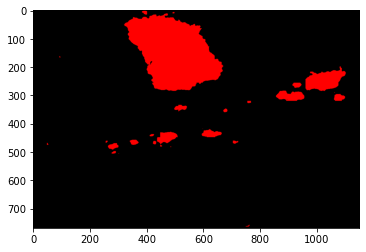

In [115]:
result = Image.new('RGB',(1152,768))
x = 0
y=0
z=0
for i in range(12):
    for j in range(18):
        result.paste(pred[z],box=(x+j*64,y+i*64))
        z +=1
plt.imshow(result)
result.save('output/out70.jpg')

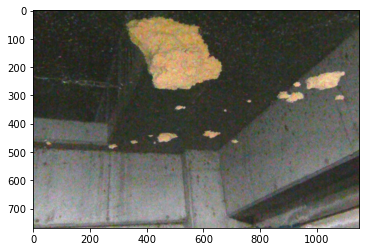

In [116]:
result2 = Image.new('RGB',(1152,768))
x = 0
y=0
z=0
for i in range(12):
    for j in range(18):
        result2.paste(ori[z],box=(x+j*64,y+i*64))
        z +=1

img = np.asarray(result2)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
r2 = Image.fromarray(img)
r2.save('output/out71.jpg')

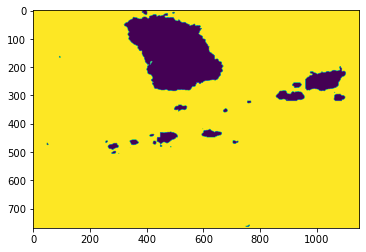

In [117]:
img1=np.asarray(result)
img2 = np.asarray(result2)


hsv1 = cv2.cvtColor(img1,cv2.COLOR_RGB2HSV)
lower_black=np.array([0,0,0])
upper_black=np.array([180,255,46])
mask = cv2.inRange(hsv1, lower_black, upper_black)
plt.imshow(mask)

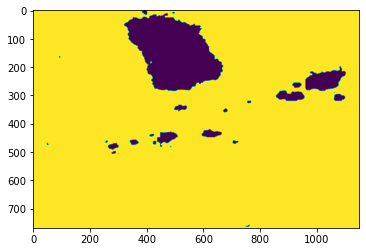

In [118]:
erode=cv2.erode(mask,None,iterations=1)
dilate=cv2.dilate(erode,None,iterations=1)
plt.imshow(dilate)

0.08735487196180555


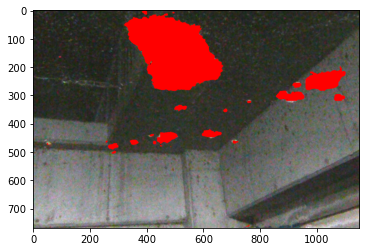

In [119]:
center=[0,0]#在新背景图片中的位置
image = tf.zeros_like(img1)
image = np.array(image)
img1 =np.array(result)
img2 =np.array(img)
m = 0
for i in range(768):
    for j in range(1152):
        if dilate[i,j]==0:#0代表黑色的点
            image[i,j]=img1[i,j]
            m +=1
        else:
            image[i,j]=img2[i,j]
plt.imshow(image)
print(m/884736)
ii = Image.fromarray(image)
ii.save('output/out72.jpg')

In [178]:
type(img1)

numpy.ndarray

In [172]:
image[1,1]


array([0, 0, 0], dtype=uint8)

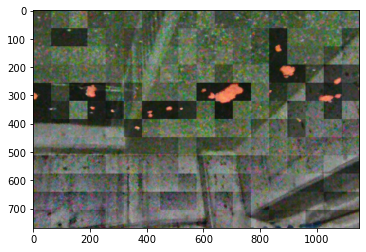

In [105]:
import matplotlib.pyplot as plt
aa =os.listdir('result')
aa.sort(key = lambda x:int(x[:-4]))
ims =[]
for f in aa:
    pa = os.path.join('result',f)
    img =Image.open(pa)
    ims.append(img)


result = Image.new('RGB',(1152,768))
x = 0
y=0
z=0
for i in range(12):
    for j in range(18):
        result.paste(ims[z],box=(x+j*64,y+i*64))
        z +=1
plt.imshow(result)
# result.save('output/out22.jpg')

In [98]:
model.save_weights('model/FCN8_1223/model')

In [95]:
model.load_weights('model/deeplabv3_1223/model')